<font size="6"> Table of Contents</font>
<a id='destination_cell_10'></a> <br>

[Importing Data and PreProcessing](#destination_cell_1)<br>
[EDA: selftext](#destination_cell_2) <br>
[EDA: title](#destination_cell_12) <br>
[EDA: Non-text Features](#destination_cell_8) <br>
[Logistic_Regression_1_selftext](#destination_cell_3) <br>
[Logistic_Regression_2_title](#destination_cell_4)<br>
[Regression Tree (CART)](#destination_cell_6) <br>
[Random Forest](#destination_cell_17) <br>
[Knn](#destination_cell_18) <br>
[AdaBoost](#destination_cell_16) <br>




In [1]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from collections import Counter


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)
pd.set_option('mode.chained_assignment', None)

In [3]:
pwd

'/Users/nicholassanso/Desktop/GA/projects/project-3/Project_3_Final_Nicholas_Sanso/code'

<font size="8">Importing Data and Preprocessing</font>
<a id='destination_cell_1'></a>

[Return to Table of Contents](#destination_cell_10)

In [5]:
import pandas as pd

dataframes = []
for i in range(1, 12):
    filename = f'../data/investing_{i}.csv'
    df = pd.read_csv(filename)
    dataframes.append(df)

df_investing = pd.concat(dataframes, axis=0, ignore_index=True)


In [6]:
df_investing.shape

(10221, 33)

In [8]:
#read in the csv files for stocks
dataframes = []
for i in range(1, 12):
    filename = f'../data/stocks_{i}.csv'
    df = pd.read_csv(filename)
    dataframes.append(df)

df_stocks = pd.concat(dataframes, axis=0, ignore_index=True)

In [9]:
df_stocks.shape

(10111, 33)

In [10]:
#Drop duplicate submissions that were scraped from the subreddit
df_investing = df_investing.drop_duplicates(subset=['name'])
df_stocks = df_stocks.drop_duplicates(subset=['name'])


print(df_stocks.shape)
print(df_investing.shape)

(1039, 33)
(1080, 33)


In [11]:
#check nulls to see if any features have so many missing values as to be avoided altogether
print(df_stocks.isnull().sum())
print(df_investing.isnull().sum())

Unnamed: 0            0
subreddit             0
selftext              0
selftext_html         0
author_fullname       0
                   ... 
num_crossposts        0
media              1039
is_video              0
id                 1038
name                  1
Length: 33, dtype: int64
Unnamed: 0            0
subreddit             0
selftext              0
selftext_html         0
author_fullname       0
                   ... 
num_crossposts        0
media              1080
is_video              0
id                 1079
name                  1
Length: 33, dtype: int64


<font size="6">Preprocessing</font>


In [12]:
#Drop the name column from each before concactenating them
df_stocks = df_stocks.dropna(subset=['name'])
df_investing = df_investing.dropna(subset=['name'])


In [13]:
df_combined = pd.concat([df_investing,df_stocks], axis=0, ignore_index=True)

In [14]:
df_combined.drop('Unnamed: 0', axis=1, inplace= True)

In [15]:
df_combined.columns

Index(['subreddit', 'selftext', 'selftext_html', 'author_fullname', 'title',
       'ups', 'total_awards_received', 'category', 'score',
       'is_created_from_ads_ui', 'is_self', 'created', 'author_flair_richtext',
       'whitelist_status', 'allow_live_comments', 'likes', 'suggested_sort',
       'banned_at_utc', 'view_count', 'archived', 'pinned', 'over_18',
       'locked', 'num_reports', 'subreddit_id', 'num_comments', 'created_utc',
       'num_crossposts', 'media', 'is_video', 'id', 'name'],
      dtype='object')

In [16]:
# there shouldn't be any duplicates at this point, but drop again just to double check 
df_combined = df_combined.drop_duplicates(subset=['name'])

In [17]:
# create functions that will count the characters, words, and sentences
def count_characters(text):
    # remove whitespace characters
    text = text.replace(' ', '').replace('\n', '').replace('\t', '')
    # return the length of the text
    return len(text)

def count_words(text):
    # split the text into words
    words = text.split()
    # return the number of words
    return len(words)

def count_sentences(text):
    sentences = sent_tokenize(text)
    return len(sentences)

In [18]:
#Implement the funcitons to create features that will count the absolute value of the characters, words, and sentences

# apply the functions to the title column
df_combined['character_count_title'] = df_combined['title'].apply(count_characters)
df_combined['word_count_title'] = df_combined['title'].apply(count_words)
df_combined['sentences_count_title'] = df_combined['title'].apply(count_sentences)

# apply the functions to the selftext column
df_combined['character_count_selftext'] = df_combined['selftext'].apply(count_characters)
df_combined['word_count_selftext'] = df_combined['selftext'].apply(count_words)
df_combined['sentences_count_selftext'] = df_combined['selftext'].apply(count_sentences)

#Create features that represent the ratios between characters, words, and sentences

# calculate the ratios for the title column
df_combined['char_over_sent_title'] = df_combined['character_count_title'] / df_combined['sentences_count_title']
df_combined['char_over_word_title'] = df_combined['character_count_title'] / df_combined['word_count_title']
df_combined['word_over_sent_title'] = df_combined['word_count_title'] / df_combined['sentences_count_title']

# calculate the ratios for the selftext column
df_combined['char_over_sent_selftext'] = df_combined['character_count_selftext'] / df_combined['sentences_count_selftext']
df_combined['char_over_word_selftext'] = df_combined['character_count_selftext'] / df_combined['word_count_selftext']
df_combined['word_over_sent_selftext'] = df_combined['word_count_selftext'] / df_combined['sentences_count_selftext']

In [19]:
df_combined['title_cleaned_1'] = df_combined['title'].apply(lambda x: re.sub(r'[\n\t\s] ', ' ' , x))
df_combined['selftext_cleaned_1'] = df_combined['selftext'].apply(lambda x: re.sub(r'[\n\t\s] ', ' ' , x))

In [20]:
#Remove special characters to create more meaningful tokens
df_combined['title_cleaned_2'] = df_combined['title_cleaned_1'].apply(lambda x: re.sub(r'[^w\s]', '', x))
df_combined['selftext_cleaned_2'] = df_combined['selftext_cleaned_1'].apply(lambda x: re.sub(r'[^w\s]', '', x))

In [21]:
#Lemmatize!
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

In [22]:
#lemmatize the columns, grab the regex-cleaned columns
df_combined['title_lemmatized'] = df_combined['title_cleaned_2'].apply(lemmatize_text)
df_combined['selftext_lemmatized'] = df_combined['selftext_cleaned_2'].apply(lemmatize_text)

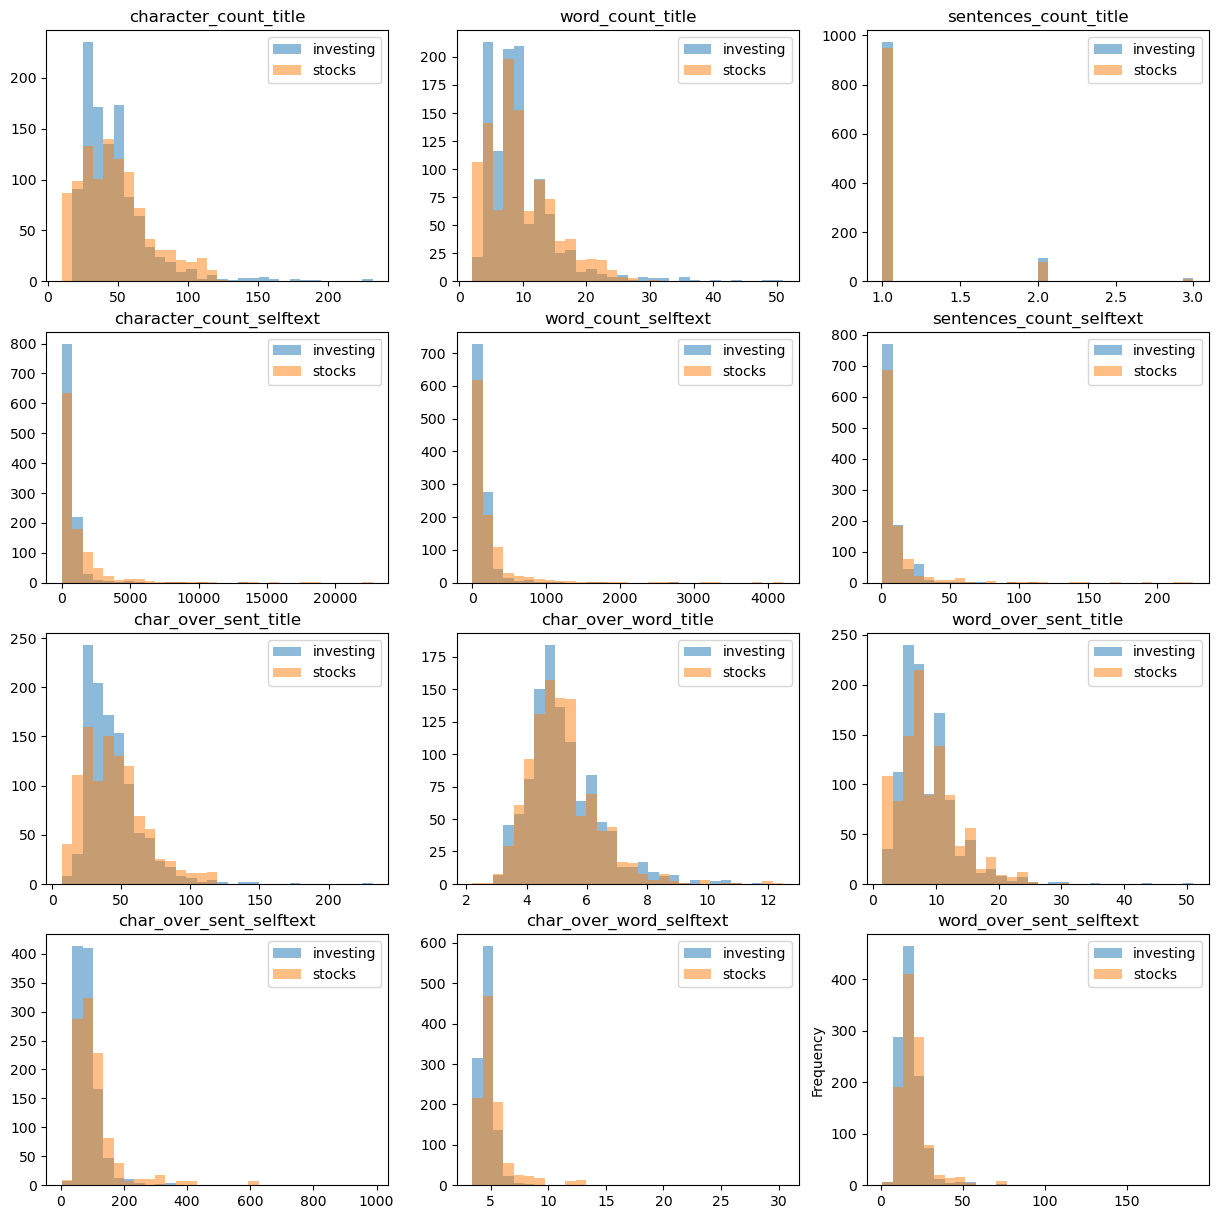

In [23]:
#Create histrograms that represent the distributions of the absolute values of characters, words, and sentences.
#Create histograms that represent the distributions of the ratio 

# define the columns for which to create histograms
columns = ['character_count_title', 'word_count_title', 'sentences_count_title',
           'character_count_selftext', 'word_count_selftext', 'sentences_count_selftext',
           'char_over_sent_title', 'char_over_word_title', 'word_over_sent_title',
           'char_over_sent_selftext', 'char_over_word_selftext', 'word_over_sent_selftext']

# get the unique values of the subreddit column
subreddits = df_combined['subreddit'].unique()

# create a figure with multiple subplots
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))

# iterate over the columns and create overlaid histograms for each column
for i, col in enumerate(columns):
    # calculate the bin edges for the current column
    data = df_combined[col]
    bins = np.histogram_bin_edges(data, bins=30)
    
    for subreddit in subreddits:
        # get the data for the current subreddit
        data = df_combined[df_combined['subreddit'] == subreddit][col]
        
        # create a histogram for the current subreddit using the calculated bin edges
        axs[i // 3, i % 3].hist(data, bins=bins, alpha=0.5, label=subreddit)
    
    # set the title and add a legend
    axs[i // 3, i % 3].set_title(col)
    axs[i // 3, i % 3].legend()

plt.ylabel('Frequency')
# display the figure
plt.show()

<font size="8">EDA: Selftext</font>
<a id='destination_cell_2'></a>

[Return to Table of Contents](#destination_cell_10)

<font size="4">EDA: selftext: sentences</font>


In [24]:
#Attention: the following EDA functions use the data from the combined dataframe (df_combined) before removing grammar (in order to count sentences).
#Attention: the following EDA was performed before lemmatization (it would impact the character count arbitrarily)

# create a new DataFrame with only the rows where subreddit is 'investing'
df_sentence_counter_investing = df_combined[df_combined['subreddit'] == 'investing']
# apply the function to the selftext column to create a new column with the sentence counts
df_sentence_counter_investing['sentence_count'] = df_combined['selftext'].apply(count_sentences)


# create a new DataFrame with only the rows where subreddit is 'stocks'
df_sentence_counter_stocks = df_combined[df_combined['subreddit'] == 'stocks']
# apply the function to the selftext column to create a new column with the sentence counts
df_sentence_counter_stocks['sentence_count'] = df_stocks['selftext'].apply(count_sentences)


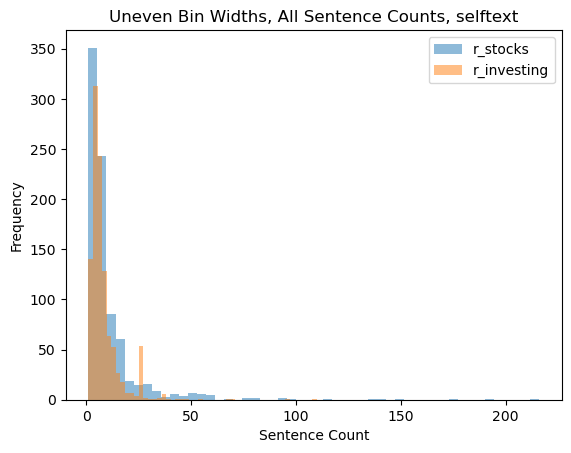

In [25]:
### plot a histogram of the sentence counts for stocks subreddit with custom opacity
df_sentence_counter_stocks['sentence_count'].plot.hist(alpha=.5, bins=50, label='r_stocks')

#plot a histogram of the sentence counts for investing subreddit with custom opacity
df_sentence_counter_investing['sentence_count'].plot.hist(alpha=.5, bins=50, label='r_investing')

# add labels and legend
plt.xlabel('Sentence Count')
plt.ylabel('Frequency')
plt.title('Uneven Bin Widths, All Sentence Counts, selftext')
plt.legend()
plt.show()

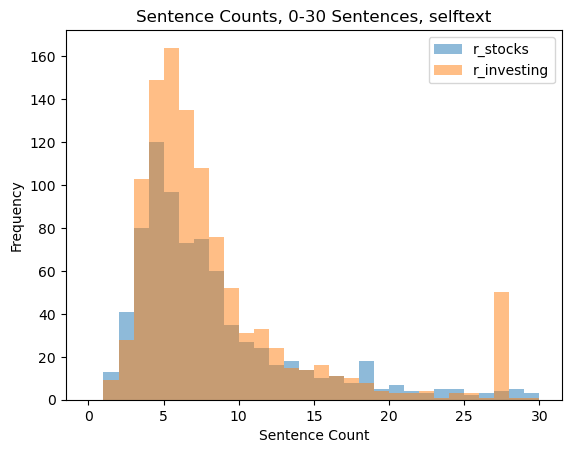

In [26]:
# plot a histogram of the sentence counts for stocks subreddit with custom opacity
df_sentence_counter_stocks['sentence_count'].plot.hist(alpha=.5, bins=30, range=(0,30),  label='r_stocks')

#plot a histogram of the sentence counts for investing subreddit with custom opacity
df_sentence_counter_investing['sentence_count'].plot.hist(alpha=.5, bins=30, range=(0,30), label='r_investing')

# add labels and legend
plt.xlabel('Sentence Count')
plt.ylabel('Frequency')
plt.legend()
plt.title('Sentence Counts, 0-30 Sentences, selftext')
plt.show()


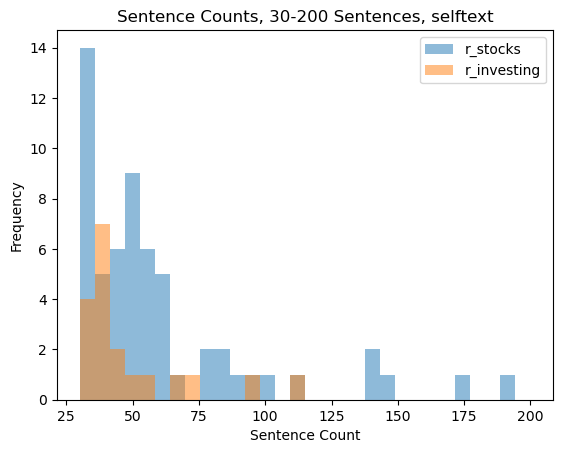

In [27]:
# plot a histogram of the sentence counts for stocks subreddit with custom opacity
df_sentence_counter_stocks['sentence_count'].plot.hist(alpha=.5, bins=30, range=(30,200),  label='r_stocks')

#plot a histogram of the sentence counts for investing subreddit with custom opacity
df_sentence_counter_investing['sentence_count'].plot.hist(alpha=.5, bins=30, range=(30, 200), label='r_investing')

# add labels and legend
plt.xlabel('Sentence Count')
plt.ylabel('Frequency')
plt.legend()
plt.title('Sentence Counts, 30-200 Sentences, selftext')
plt.show()


<font size="4">EDA: selftext: characters</font>


In [28]:
# create a new DataFrame with only the rows where subreddit is 'stocks'
df_character_counter_stocks_selftext = df_combined[df_combined['subreddit'] == 'stocks']
# apply the function to the selftext column to create a new column with the sentence counts
df_character_counter_stocks_selftext['character_count'] = df_character_counter_stocks_selftext['selftext'].apply(count_characters)

# create a new DataFrame with only the rows where subreddit is 'investing'
df_character_counter_investing_selftext = df_combined[df_combined['subreddit'] == 'investing']
# apply the function to the selftext column to create a new column with the sentence counts
df_character_counter_investing_selftext['character_count'] = df_character_counter_investing_selftext['selftext'].apply(count_characters)

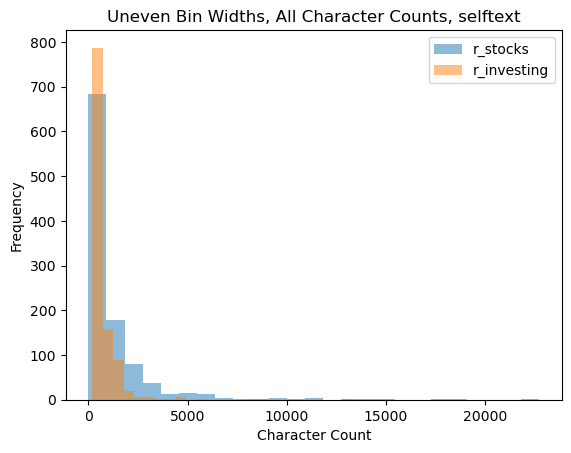

In [29]:
# plot a histogram of the sentence counts for stocks subreddit with custom opacity
df_character_counter_stocks_selftext['character_count'].plot.hist(alpha=.5, bins=25, label='r_stocks')

#plot a histogram of the sentence counts for investing subreddit with custom opacity
df_character_counter_investing_selftext['character_count'].plot.hist(alpha=.5, bins=25, label='r_investing')

# add labels and legend
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.title('Uneven Bin Widths, All Character Counts, selftext')
plt.legend()
plt.show()

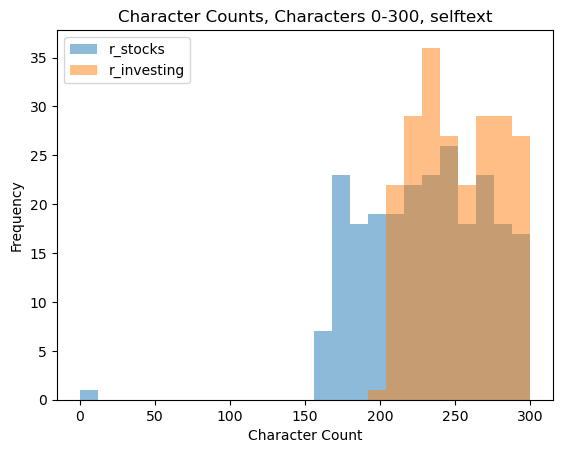

In [30]:
# plot a histogram of the sentence counts for stocks subreddit with custom opacity
df_character_counter_stocks_selftext['character_count'].plot.hist(alpha=.5, bins=25, range=(0,300), label='r_stocks')

#plot a histogram of the sentence counts for investing subreddit with custom opacity
df_character_counter_investing_selftext['character_count'].plot.hist(alpha=.5, bins=25, range=(0,300), label='r_investing')

# add labels and legend
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.title('Character Counts, Characters 0-300, selftext')
plt.legend()
plt.show()

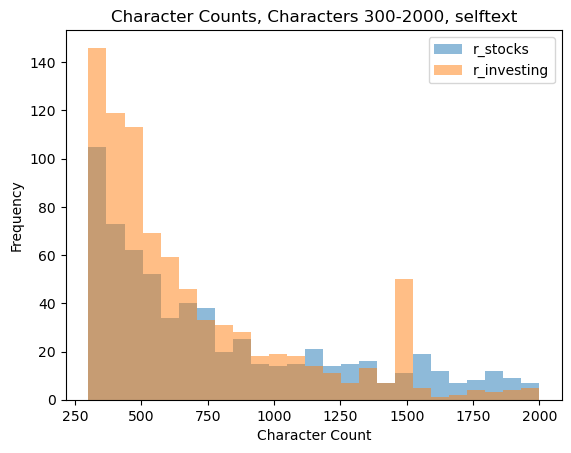

In [31]:
# plot a histogram of the sentence counts for stocks subreddit with custom opacity
df_character_counter_stocks_selftext['character_count'].plot.hist(alpha=.5, bins=25, range=(300,2000), label='r_stocks')

#plot a histogram of the sentence counts for investing subreddit with custom opacity
df_character_counter_investing_selftext['character_count'].plot.hist(alpha=.5, bins=25, range=(300,2000), label='r_investing')

# add labels and legend
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.title('Character Counts, Characters 300-2000, selftext')
plt.legend()
plt.show()

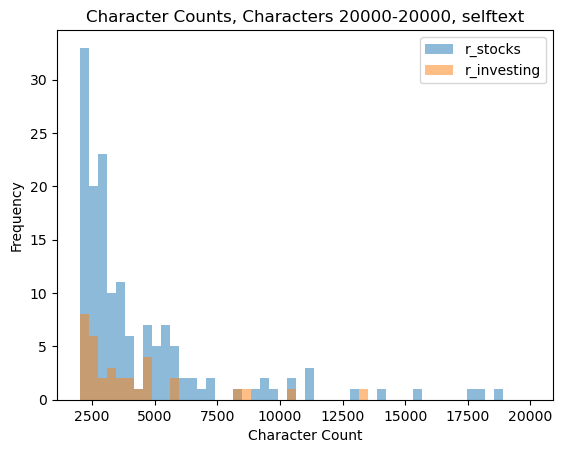

In [32]:
# plot a histogram of the sentence counts for stocks subreddit with custom opacity
df_character_counter_stocks_selftext['character_count'].plot.hist(alpha=.5, bins=50, range=(2000,20000), label='r_stocks')

#plot a histogram of the sentence counts for investing subreddit with custom opacity
df_character_counter_investing_selftext['character_count'].plot.hist(alpha=.5, bins=50, range=(2000,20000), label='r_investing')

# add labels and legend
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.title('Character Counts, Characters 20000-20000, selftext')
plt.legend()
plt.show()

<font size="4">EDA: selftext: words</font>


In [33]:
# create a new DataFrame with only the rows where subreddit is 'stocks'
df_word_counter_stocks_selftext = df_combined[df_combined['subreddit'] == 'stocks']
# apply the function to the selftext column to create a new column with the sentence counts
df_word_counter_stocks_selftext['word_count'] = df_character_counter_stocks_selftext['selftext'].apply(count_characters)

# create a new DataFrame with only the rows where subreddit is 'investing'
df_word_counter_investing_selftext = df_combined[df_combined['subreddit'] == 'investing']
# apply the function to the selftext column to create a new column with the sentence counts
df_word_counter_investing_selftext['word_count'] = df_word_counter_investing_selftext['selftext'].apply(count_characters)

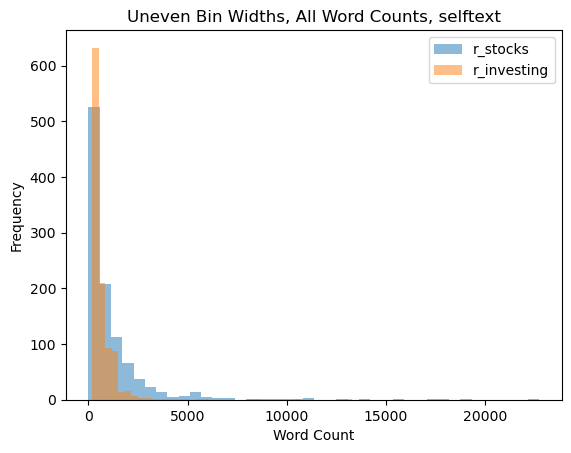

In [34]:
# plot a histogram of the sentence counts for stocks subreddit with custom opacity
df_word_counter_stocks_selftext['word_count'].plot.hist(alpha=.5, bins=40, label='r_stocks')

#plot a histogram of the sentence counts for investing subreddit with custom opacity
df_word_counter_investing_selftext['word_count'].plot.hist(alpha=.5, bins=40, label='r_investing')

# add labels and legend
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Uneven Bin Widths, All Word Counts, selftext')
plt.legend()
plt.show()

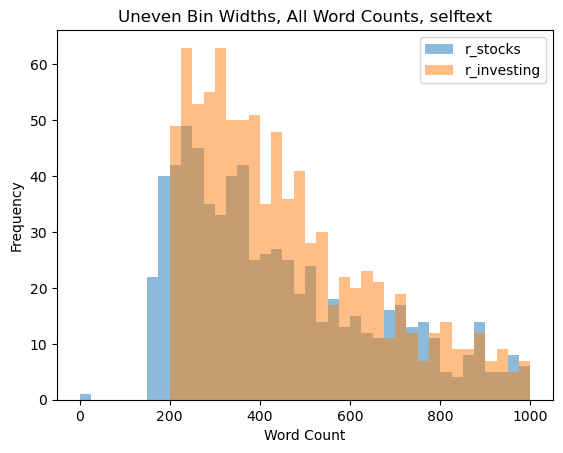

In [35]:
# plot a histogram of the sentence counts for stocks subreddit with custom opacity
df_word_counter_stocks_selftext['word_count'].plot.hist(alpha=.5, bins=40, range=(0,1000), label='r_stocks')

#plot a histogram of the sentence counts for investing subreddit with custom opacity
df_word_counter_investing_selftext['word_count'].plot.hist(alpha=.5, bins=40, range=(0,1000), label='r_investing')

# add labels and legend
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Uneven Bin Widths, All Word Counts, selftext')
plt.legend()
plt.show()

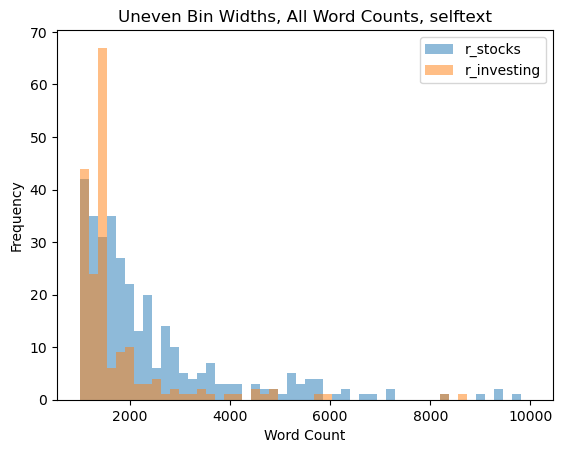

In [36]:
# plot a histogram of the sentence counts for stocks subreddit with custom opacity
df_word_counter_stocks_selftext['word_count'].plot.hist(alpha=.5, bins=50, range=(1000,10000), label='r_stocks')

#plot a histogram of the sentence counts for investing subreddit with custom opacity
df_word_counter_investing_selftext['word_count'].plot.hist(alpha=.5, bins=50, range=(1000,10000), label='r_investing')

# add labels and legend
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Uneven Bin Widths, All Word Counts, selftext')
plt.legend()
plt.show()

<font size="8">EDA: title</font>
<a id='destination_cell_12'></a>

[Return to Table of Contents](#destination_cell_10)

<font size="4">EDA: title: Sentences</font>


In [37]:
# create a new DataFrame with only the rows where subreddit is 'investing'
df_character_counter_investing = df_combined[df_combined['subreddit'] == 'investing']
# apply the function to the selftext column to create a new column with the sentence counts
df_character_counter_investing['character_count'] = df_character_counter_investing['title'].apply(count_characters)


# create a new DataFrame with only the rows where subreddit is 'stocks'
df_character_counter_stocks = df_combined[df_combined['subreddit'] == 'stocks']
# apply the function to the selftext column to create a new column with the sentence counts
df_character_counter_stocks['character_count'] = df_character_counter_stocks['title'].apply(count_characters)


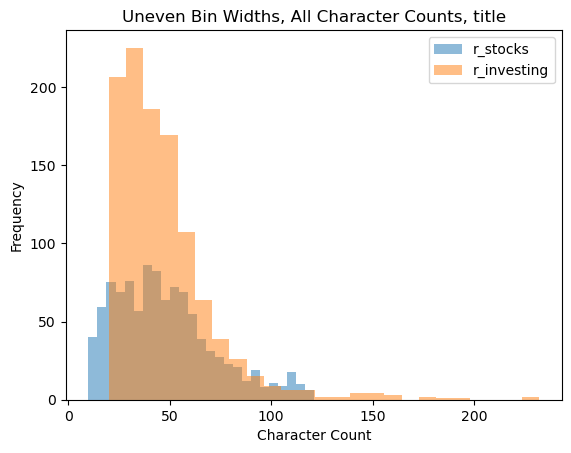

In [38]:
# plot a histogram of the sentence counts for stocks subreddit with custom opacity
df_character_counter_stocks['character_count'].plot.hist(alpha=.5, bins=25, label='r_stocks')

#plot a histogram of the sentence counts for investing subreddit with custom opacity
df_character_counter_investing['character_count'].plot.hist(alpha=.5, bins=25, label='r_investing')

# add labels and legend
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.title('Uneven Bin Widths, All Character Counts, title')
plt.legend()
plt.show()

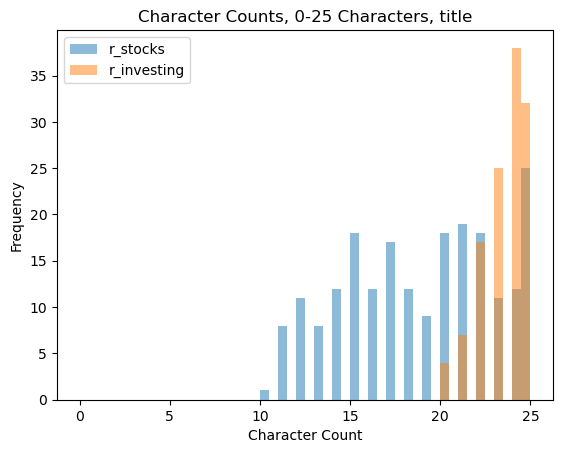

In [39]:
# plot a histogram of the sentence counts for stocks subreddit with custom opacity
df_character_counter_stocks['character_count'].plot.hist(alpha=.5, bins=50, range=(0,25), label='r_stocks')

#plot a histogram of the sentence counts for investing subreddit with custom opacity
df_character_counter_investing['character_count'].plot.hist(alpha=.5, bins=50, range=(0,25), label='r_investing')

# add labels and legend
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.title('Character Counts, 0-25 Characters, title')
plt.legend()
plt.show()

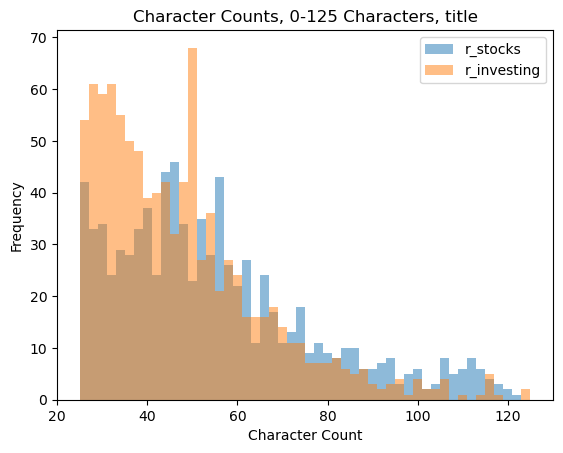

In [40]:
# plot a histogram of the sentence counts for stocks subreddit with custom opacity
df_character_counter_stocks['character_count'].plot.hist(alpha=.5, bins=50, range=(25,125), label='r_stocks')

#plot a histogram of the sentence counts for investing subreddit with custom opacity
df_character_counter_investing['character_count'].plot.hist(alpha=.5, bins=50, range=(25,125), label='r_investing')

# add labels and legend
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.title('Character Counts, 0-125 Characters, title')
plt.legend()
plt.show()

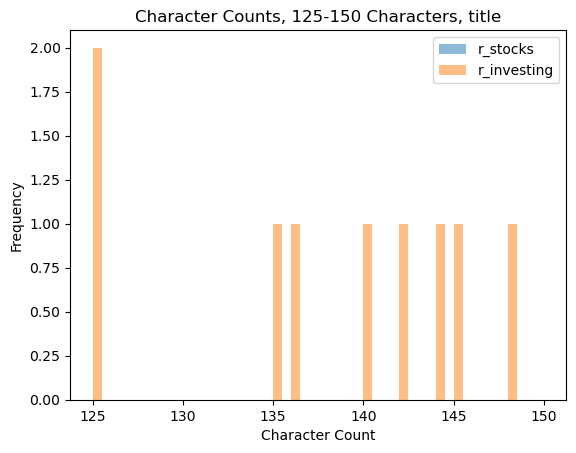

In [41]:
# show that r_investing has high frequencies at the higher character counts in titles 

# plot a histogram of the sentence counts for stocks subreddit with custom opacity
df_character_counter_stocks['character_count'].plot.hist(alpha=.5, bins=50, range=(125,150), label='r_stocks')

# plot a histogram of the sentence counts for investing subreddit with custom opacity
df_character_counter_investing['character_count'].plot.hist(alpha=.5, bins=50, range=(125,150), label='r_investing')

# add labels and legend
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.title('Character Counts, 125-150 Characters, title')
plt.legend()
plt.show()

<font size="4">EDA: title: Sentences</font>


In [42]:
# create a new DataFrame with only the rows where subreddit is 'investing'
df_sentence_counter_investing_title = df_combined[df_combined['subreddit'] == 'investing']
# apply the function to the selftext column to create a new column with the sentence counts
df_sentence_counter_investing_title['sentence_count'] = df_combined['title'].apply(count_sentences)


# create a new DataFrame with only the rows where subreddit is 'stocks'
df_sentence_counter_stocks_title = df_combined[df_combined['subreddit'] == 'stocks']
# apply the function to the selftext column to create a new column with the sentence counts
df_sentence_counter_stocks_title['sentence_count'] = df_stocks['title'].apply(count_sentences)

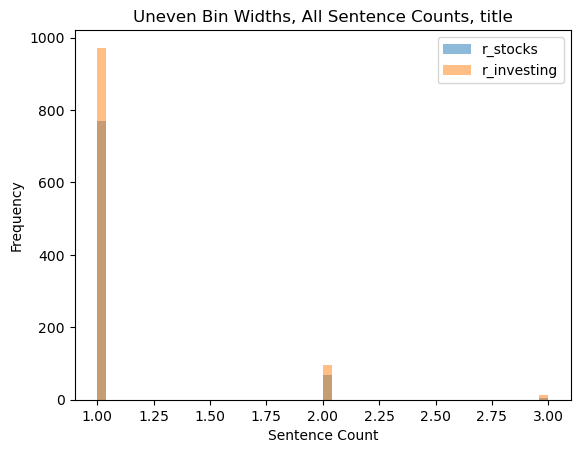

In [43]:
# plot a histogram of the sentence counts for stocks subreddit with custom opacity
df_sentence_counter_stocks_title['sentence_count'].plot.hist(alpha=.5, bins=50, label='r_stocks')

#plot a histogram of the sentence counts for investing subreddit with custom opacity
df_sentence_counter_investing_title['sentence_count'].plot.hist(alpha=.5, bins=50, label='r_investing')

# add labels and legend
plt.xlabel('Sentence Count')
plt.ylabel('Frequency')
plt.title('Uneven Bin Widths, All Sentence Counts, title')
plt.legend()
plt.show()

In [44]:
# create a new DataFrame with only the rows where subreddit is 'investing'
df_character_counter_investing_title = df_combined[df_combined['subreddit'] == 'investing']
# apply the function to the selftext column to create a new column with the sentence counts
df_character_counter_investing_title['character_count'] = df_character_counter_investing_title['title'].apply(count_characters)


# create a new DataFrame with only the rows where subreddit is 'stocks'
df_character_counter_stocks_title = df_combined[df_combined['subreddit'] == 'stocks']
# apply the function to the selftext column to create a new column with the sentence counts
df_character_counter_stocks_title['character_count'] = df_character_counter_stocks_title['title'].apply(count_characters)

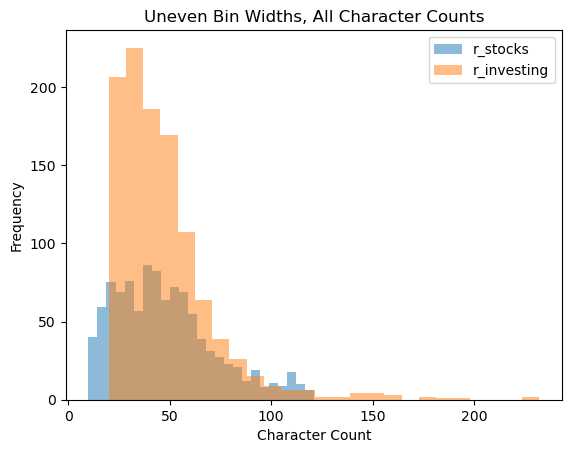

In [45]:
# plot a histogram of the sentence counts for stocks subreddit with custom opacity
df_character_counter_stocks_title['character_count'].plot.hist(alpha=.5, bins=25, label='r_stocks')

#plot a histogram of the sentence counts for investing subreddit with custom opacity
df_character_counter_investing_title['character_count'].plot.hist(alpha=.5, bins=25, label='r_investing')

# add labels and legend
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.title('Uneven Bin Widths, All Character Counts')
plt.legend()
plt.show()

<font size="8">EDA: Non-text Features</font>
<a id='destination_cell_8'></a>

[Return to Table of Contents](#destination_cell_10)

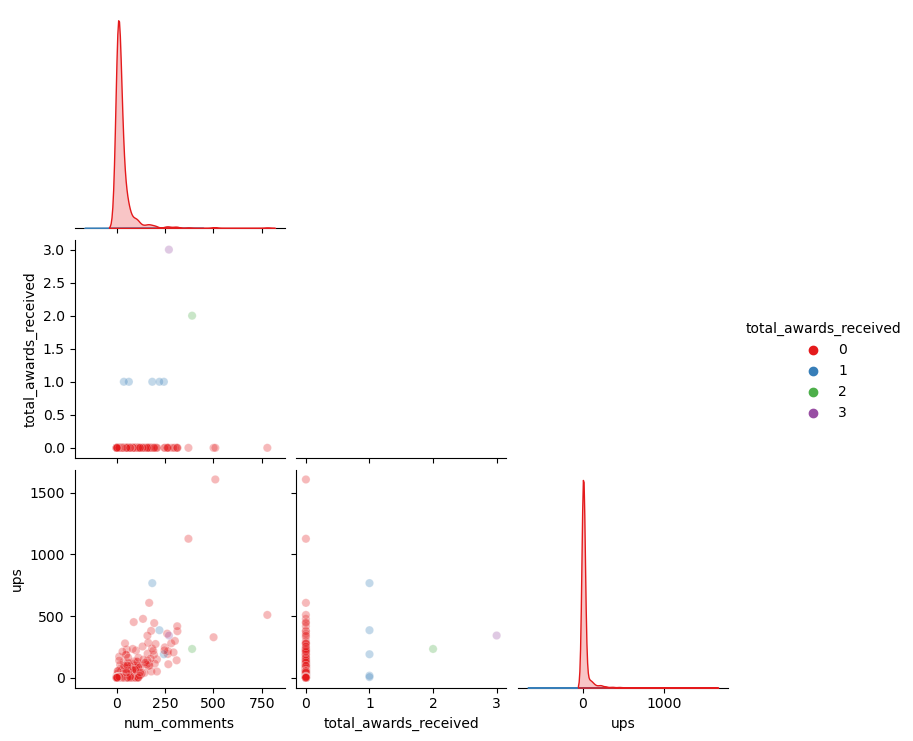

In [46]:
pairplot_columns = df_investing[['num_comments', 'total_awards_received', 'ups']]
sns.pairplot(df_investing, vars=pairplot_columns, hue='total_awards_received', plot_kws={'alpha': 0.3}, corner=True, palette='Set1')

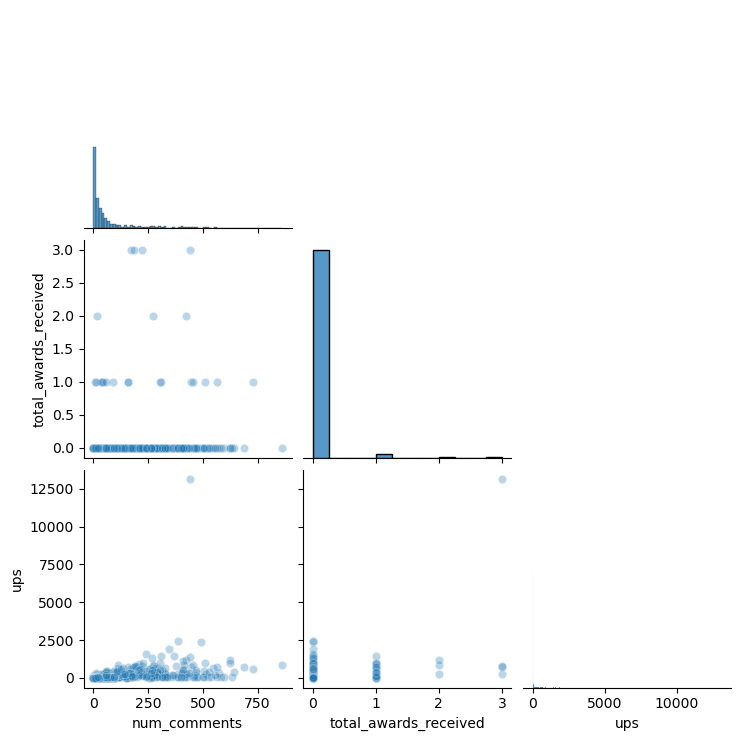

In [47]:
pairplot_columns=df_investing[['num_comments','total_awards_received','ups']]
sns.pairplot(df_stocks, vars=pairplot_columns,plot_kws= {'alpha':0.3}, corner= True)

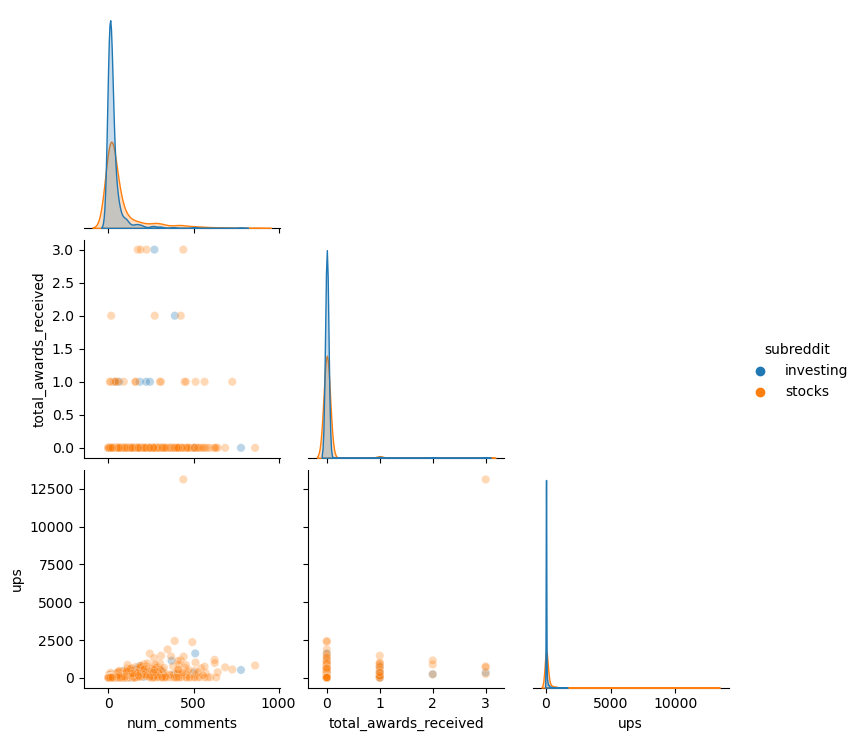

In [48]:
# Select the columns to include in the pairplot
pairplot_columns = ['num_comments', 'total_awards_received', 'ups']

# Concatenate the two dataframes
df_combined_2 = pd.concat([df_investing, df_stocks], ignore_index=True)

# Create a pairplot of the combined dataframe, coloring the observations according to the "dataframe" column
sns.pairplot(df_combined_2, vars=pairplot_columns, hue='subreddit', plot_kws= {'alpha':0.3}, corner= True);

In [49]:
def tf_sum(document, corpus):
    # Create a TfidfVectorizer object with use_idf=False
    vectorizer = TfidfVectorizer(use_idf=False)
    
    # Fit the vectorizer on the corpus
    X = vectorizer.fit_transform(corpus)
    
    # Transform the input document
    doc_vec = vectorizer.transform([document])
    
    # Get the term frequency array for the input document
    tf_array = doc_vec.toarray()[0]
    
    # Calculate the sum of term frequencies
    tf_sum = tf_array.sum()
    
    # Calculate the total number of terms in the input document
    num_terms = len(document.split())
    
    # Return the result
    return tf_sum / num_terms


In [50]:
# define the corpus
corpus = df_combined['title']

# split the corpus into individual words
words = []
for text in corpus:
    for word in text.split():
        # only add the word to the list if it is not a stop word
        if word.lower() not in ENGLISH_STOP_WORDS:
            words.append(word)

# count the frequency of each word
word_counts = Counter(words)

# create a DataFrame with the word counts
df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['count'])

# sort the DataFrame by count in descending order
df = df.sort_values(by='count', ascending=False)

# display the resulting DataFrame
print(df)

             count
-              239
stock          138
2023           129
Discussion      98
Daily           84
...            ...
$500             1
Safety           1
subsidiary,      1
Wizards          1
subscriber       1

[5826 rows x 1 columns]


In [51]:
# define the corpus
corpus = df_stocks['title']

# split the corpus into individual words
words = []
for text in corpus:
    for word in text.split():
        # only add the word to the list if it is not a stop word
        if word.lower() not in ENGLISH_STOP_WORDS:
            words.append(word)

# count the frequency of each word
word_counts = Counter(words)

# create a DataFrame with the word counts
df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['count'])

# sort the DataFrame by count in descending order
df = df.sort_values(by='count', ascending=False)

# display the resulting DataFrame
print(df)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 60)



            count
stock         107
-             107
2023           72
stocks         54
&amp;          50
...           ...
KRE             1
trades          1
NCBO?           1
Asml            1
subscriber      1

[3603 rows x 1 columns]


In [52]:
#Create the base model, in which we predict the majority class
print(df_stocks.shape)
print(df_investing.shape)
base_accuracy = 1079 / (1038 + 1079)
f"Base Model, Predict the majority class: {base_accuracy:.2f}"


(1038, 33)
(1079, 33)


'Base Model, Predict the majority class: 0.51'


<font size="8">Logistic_Regression_1_selftext</font>
<a id='destination_cell_3'></a>

[Return to Table of Contents](#destination_cell_10)

In [53]:
X = df_combined['selftext']
y = df_combined['subreddit']

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [54]:
# Step 1 instantiate the TfidVectorizer and LogisticRegression
tvec = TfidfVectorizer(stop_words='english')
logreg = LogisticRegression(solver = 'liblinear', random_state= 42, max_iter=2000)


# Step 2: Create a pipeline
pipe_selftext = Pipeline([
    ('tvec', tvec),
    ('logreg', logreg)
])

# # Step 3: Define the parameter grid
param_grid = {
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'tvec__max_df': [0.5, 0.75, 1.0],
    'tvec__min_df': [1, 2, 3],
    'logreg__C': [0.1, 1, 10],
    'logreg__penalty': ['l1', 'l2']
}

# Step 4: Create a GridSearchCV instance
grid_search = GridSearchCV(pipe_selftext, param_grid)


# Step 5: Fit the GridSearchCV instance on the data SHOULD THIS B "B_TRAIN?"
grid_search.fit(X_train, y_train)

# Step 6: Print the best parameters
print(grid_search.best_params_)
 

{'logreg__C': 1, 'logreg__penalty': 'l2', 'tvec__max_df': 0.5, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 1)}


In [55]:
# Fit the pipeline on the training data
pipe_selftext.fit(X_train, y_train)

# Compute the accuracy on the training data
train_acc = pipe_selftext.score(X_train, y_train)
print(train_acc)
# Compute the accuracy on the validation data
val_acc = pipe_selftext.score(X_val, y_val)
print(val_acc)


0.9004410838059231
0.7773584905660378


In [56]:
scores = cross_val_score(pipe_selftext, X_train, y_train, cv=5)
print(scores)
print(scores.mean())
scores.std()

[0.74842767 0.77358491 0.73817035 0.78233438 0.78864353]
0.7662321687201159


0.019596322445577487

<font size="8">Logistic_Regression_2_title</font>
<a id='destination_cell_4'></a>

[Return to Table of Contents](#destination_cell_10)

In [57]:
X = df_combined['title']
y = df_combined['subreddit']

In [58]:
# A_train, A_val, b_train, b_val = train_test_split(A,b,random_state=42)
X_log2_train, X_log2_val, y_log2_train, y_log2_val = train_test_split(X, y, random_state=42)

In [59]:
# Step 1 instantiate the TfidVectorizer and LogisticRegression
tvec_2 = TfidfVectorizer(stop_words='english')
logreg_2 = LogisticRegression(solver = 'liblinear', random_state= 42, max_iter=2000)

# Step 2: Create a pipeline
pipe_title = Pipeline([
    ('tvec_2', tvec_2),
    ('logreg_2', logreg_2)
])

# Step 3: Define the parameter grid
param_grid = {
    'tvec_2__ngram_range': [(1, 1), (1, 2)],
    'tvec_2__max_df': [0.5, 0.75, 1.0],
    'tvec_2__min_df': [1, 2, 3],
    'logreg_2__C': [0.1, 1, 10],
    'logreg_2__penalty': ['l1', 'l2']
}

# Step 4: Create a GridSearchCV instance
grid_search = GridSearchCV(pipe_title, param_grid)


# Step 5: Fit the GridSearchCV instance on the data SHOULD THIS B "B_TRAIN?"
grid_search.fit(X_log2_train, y_log2_train)

# Step 6: Print the best parameters
print(grid_search.best_params_)


/Users/nicholassanso/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/nicholassanso/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/nicholassanso/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/nicholassanso/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/nicholassanso/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/nicholas

{'logreg_2__C': 1, 'logreg_2__penalty': 'l2', 'tvec_2__max_df': 0.5, 'tvec_2__min_df': 2, 'tvec_2__ngram_range': (1, 2)}


In [60]:
pipe_title.fit(X_log2_train, y_log2_train)

Pipeline(steps=[('tvec_2', TfidfVectorizer(stop_words='english')),
                ('logreg_2',
                 LogisticRegression(max_iter=2000, random_state=42,
                                    solver='liblinear'))])

In [61]:
print(pipe_title.score(X_log2_train, y_log2_train))
pipe_title.score(X_log2_val, y_log2_val)

0.9010712035286704


0.7

In [62]:
scores = cross_val_score(pipe_title, X_log2_train, y_log2_train, cv=5)
print(scores)
print(scores.mean())
scores.std()

[0.72641509 0.71698113 0.69400631 0.70347003 0.73817035]
0.715808582822451


0.015757540674611298

In [63]:
# Fit the pipeline on the training data
pipe_selftext.fit(X_log2_train, y_log2_train)

# Compute the accuracy on the training data
train_acc = pipe_selftext.score(X_log2_train, y_log2_train)

# Compute the accuracy on the validation data
val_acc = pipe_selftext.score(X_log2_val, y_log2_val)


print(train_acc)
print(val_acc)


0.9010712035286704
0.7


<font size="8">Regression Tree (CART) </font>
<a id='destination_cell_6'></a>

[Return to Table of Contents](#destination_cell_10)

In [64]:
X=df_combined[['ups','num_comments','total_awards_received']]
y=df_combined['subreddit']
X_cart_train, X_cart_val, y_cart_train, y_cart_val = train_test_split(X, y, random_state=42)

In [65]:
sc = StandardScaler()

# learns the mean, stdev of each feature in the fit part, then applies the transformation
X_train_cart_sc = sc.fit_transform(X_cart_train)

# We don't fit on test set, we only transform it with mean, stdev learned from training set
X_test_cart_sc = sc.transform(X_cart_val)

# Create a new DataFrame from the transformed data, this ensures that when you go to fit the data, the data will 
# be fitted with feature names as a pandas dataframe, instead of as a numpy array
X_train_cart_sc_df = pd.DataFrame(X_train_cart_sc, columns=X_cart_train.columns)

# Create a new DataFrame from the transformed data
X_val_cart_sc_df = pd.DataFrame(X_test_cart_sc, columns=X_cart_val.columns)

In [66]:
#set max depth to a shallow number, all I want is for the model to cleave off the top of the distribution of engagement histogram 
cart= DecisionTreeClassifier(max_depth=10, random_state=42)
cart.fit(X_train_cart_sc_df,y_cart_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [67]:
# Compute the accuracy on the training data
train_cart_acc = cart.score(X_train_cart_sc_df, y_cart_train)

# Compute the accuracy on the validation data
val_cart_acc = cart.score(X_val_cart_sc_df, y_cart_val)

print(train_cart_acc)
print(val_cart_acc)

0.741650913673598
0.5792452830188679


In [68]:
scores = cross_val_score(cart, X_cart_train, y_cart_train, cv=5)
print(scores)
print(scores.mean())
scores.std()

[0.60691824 0.59119497 0.59305994 0.60883281 0.60567823]
0.6011368370930301


0.0074478710642686295

<font size="8">Random Forest </font>
<a id='destination_cell_17'></a>

[Return to Table of Contents](#destination_cell_10)

In [69]:
X=df_combined[['ups','num_comments','total_awards_received']]
y=df_combined['subreddit']
X_rf_train, X_rf_val, y_rf_train, y_rf_val = train_test_split(X, y, random_state=42)


# Instantiate a random forest classifier 
rf = RandomForestClassifier(random_state=42, max_depth=5)
rf.fit(X_rf_train,y_rf_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [70]:
# Compute the accuracy on the training data
train_rf_acc = cart.score(X_rf_train, y_rf_train)

# Compute the accuracy on the validation data
val_rf_acc = cart.score(X_rf_val, y_rf_val)

print(train_rf_acc)
print(val_rf_acc)

0.5040957781978576
0.5


In [71]:
scores = cross_val_score(rf, X_rf_train, y_rf_train, cv=5)
print(scores)
print(scores.mean())
scores.std()

[0.6509434  0.6509434  0.64353312 0.64037855 0.6466877 ]
0.6464972323076007


0.004142396759316956

<font size="8">k_nearest_neighbors </font>
<a id='destination_cell_18'></a>

[Return to Table of Contents](#destination_cell_10)

In [72]:
X=df_combined[['ups','num_comments','total_awards_received']]
y=df_combined['subreddit']
X_knn_train, X_knn_val, y_knn_train, y_knn_val = train_test_split(X, y, random_state=42)

In [73]:
# learns the mean, stdev of each feature in the fit part, then applies the transformation
X_train_knn_sc = sc.fit_transform(X_knn_train)

# We don't fit on test set, we only transform it with mean, stdev learned from training set
X_test_knn_sc = sc.transform(X_knn_val)

# Create a new DataFrame from the transformed data, this ensures that when you go to fit the data, the data will 
# be fitted with feature names as a pandas dataframe, instead of as a numpy array
X_train_knn_sc_df = pd.DataFrame(X_train_knn_sc, columns=X_knn_train.columns)

# Create a new DataFrame from the transformed data
X_val_knn_sc_df = pd.DataFrame(X_test_knn_sc, columns=X_knn_val.columns)

In [74]:
# Instantiate a kNN classifier with default parameters
knn = KNeighborsClassifier(n_neighbors=9)

# Fit the kNN classifier on the training data
knn.fit(X_train_knn_sc_df, y_knn_train)

# Compute the accuracy on the training data
train_knn_acc = knn.score(X_train_knn_sc_df, y_knn_train)

# Compute the accuracy on the validation data
val_knn_acc = knn.score(X_val_knn_sc_df, y_knn_val)

In [75]:
print(train_knn_acc)
print(val_knn_acc)

0.6798991808443604
0.6339622641509434


In [76]:
scores = cross_val_score(knn, X_train_knn_sc_df, y_knn_train, cv=5)
print(scores)
print(scores.mean())
print(scores.std())

[0.60691824 0.60691824 0.59305994 0.60567823 0.59305994]
0.6011269170485883
0.006602206264358311


<font size="8">Adaboost </font>
<a id='destination_cell_16'></a>

[Return to Table of Contents](#destination_cell_10)

In [77]:
X=df_combined[['character_count_title',
       'word_count_title', 'sentences_count_title', 'character_count_selftext',
       'word_count_selftext', 'sentences_count_selftext',
       'char_over_sent_title', 'char_over_word_title', 'word_over_sent_title',
       'char_over_sent_selftext', 'char_over_word_selftext',
       'word_over_sent_selftext']]
y=df_combined['subreddit']
X_ada_train, X_ada_val, y_ada_train, y_ada_val = train_test_split(X, y, random_state=42)

In [78]:
X_ada_val.shape

(530, 12)

In [79]:
# create a pipeline with StandardScaler, PCA, and AdaBoostRegressor
pipe_ada = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('regressor', AdaBoostClassifier())
])

# fit the pipeline on the training data
pipe_ada.fit(X_ada_train, y_ada_train)


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()),
                ('regressor', AdaBoostClassifier())])

In [80]:
# Compute the accuracy on the training data
train_ada_acc = pipe_ada.score(X_ada_train, y_ada_train)

# Compute the accuracy on the validation data
val_ada_acc = pipe_ada.score(X_ada_val, y_ada_val)

print(train_ada_acc)
print(val_ada_acc)

0.7303087586641462
0.6433962264150943


In [81]:
scores = cross_val_score(pipe_ada, X_ada_train, y_ada_train, cv=5)
print(scores)
print(scores.mean())
scores.std()

[0.64150943 0.67295597 0.69400631 0.6466877  0.66876972]
0.6647858262405015


0.019004168182472664